# Handwritten Digit Recognition

In [ ]:
from timeit import default_timer as timer
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms


In [ ]:
#device's agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


## 1. Transform Image to Tensor Format

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])


## 2. Downloading Train and Test Data

In [ ]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


## 3. Load Batch_size with DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
test_loader= torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

##4. Data Visualizing and Exploring

In [ ]:
data_counter = iter(train_loader)
images, labels = next(data_counter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


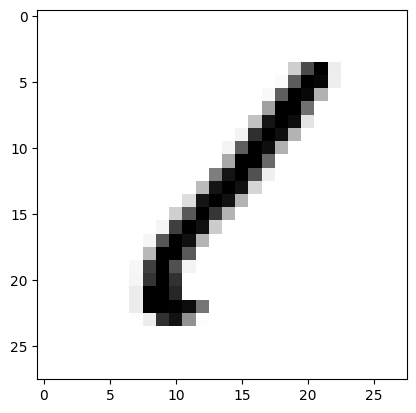

In [ ]:
# plot the first value
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

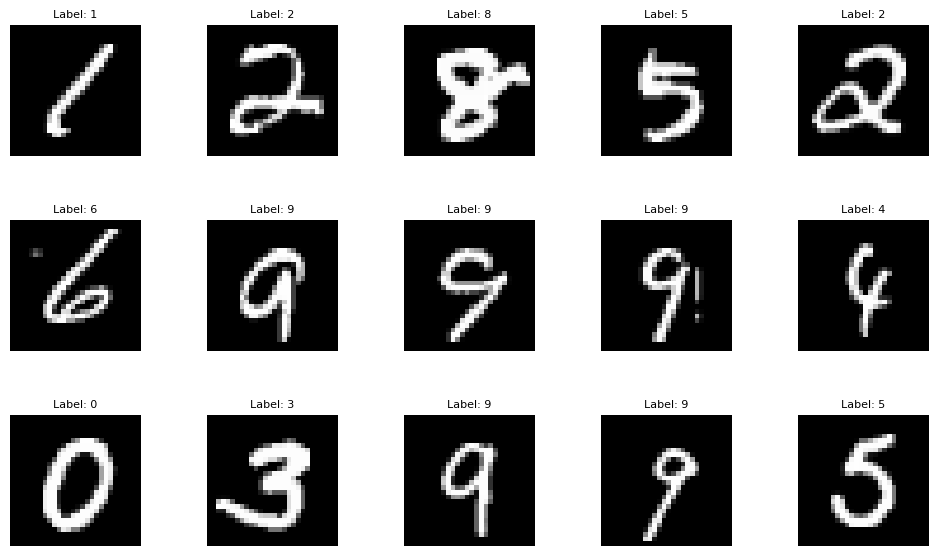

In [ ]:

#Shows 15 data within 3 rows and 5 column
num_images = 15
rows, cols = 3, 5

fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
fig.tight_layout()

for i in range(num_images):
    row = i // cols   # row no
    col = i % cols    # col no

    ax = axes[row, col]
    ax.imshow(images[i].numpy().squeeze(), cmap="gray") # plot each img
    ax.set_title(f"Label: {labels[i].item()}", fontsize=8)  # Write label name
    ax.axis("off")

## 5. Defining Model and Class

In [ ]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel,self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model_mnist = MNISTModel()
model_mnist.to(device)
model_mnist

MNISTModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Setup loss and optimizer and evaluation metrics

In [ ]:
import requests
from pathlib import Path

# download helper_function doc from pytorch learn repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

## 6. Create loss function and optimizer


In [ ]:
from  helper_functions import accuracy_fn
# setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_mnist.parameters(), lr=0.001)

## 7. Creating function to time our experiment

In [ ]:
def print_time(start:float,
               end : float,
               device:torch.device=None):
  total_time = end - start
  print(f"Time taken: {total_time:.3f} seconds")
  return total_time


## 8. Create training loop and training model

In [ ]:
from tqdm.auto import tqdm
import torch
from timeit import default_timer as timer

torch.manual_seed(42)
# --- train_step ---
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):

  ### -- Training--

    model.train()
    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Loss & accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

# --- test_step ---

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            test_loss += loss_fn(y_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc

# --- Full epoch loop ---

epochs = 20
train_time_start_on_cpu = timer()

for epoch in tqdm(range(epochs), desc="Epochs"):
    print(f"\nEpoch {epoch+1}/{epochs}\n{'-'*20}")
    train_step(model_mnist, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_step(model_mnist, test_loader, loss_fn, accuracy_fn, device)

train_time_end_on_cpu = timer()
print(f"Total training time: {train_time_end_on_cpu - train_time_start_on_cpu:.2f} seconds")


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
--------------------
Train loss: 0.16887 | Train accuracy: 94.82%
Test loss: 0.04631 | Test accuracy: 98.71%


Epoch 2/20
--------------------
Train loss: 0.05812 | Train accuracy: 98.21%
Test loss: 0.03411 | Test accuracy: 98.94%


Epoch 3/20
--------------------
Train loss: 0.04269 | Train accuracy: 98.68%
Test loss: 0.02931 | Test accuracy: 99.06%


Epoch 4/20
--------------------
Train loss: 0.03245 | Train accuracy: 98.99%
Test loss: 0.02928 | Test accuracy: 99.12%


Epoch 5/20
--------------------
Train loss: 0.02655 | Train accuracy: 99.17%
Test loss: 0.02542 | Test accuracy: 99.17%


Epoch 6/20
--------------------
Train loss: 0.02267 | Train accuracy: 99.29%
Test loss: 0.03546 | Test accuracy: 98.96%


Epoch 7/20
--------------------
Train loss: 0.01918 | Train accuracy: 99.39%
Test loss: 0.02341 | Test accuracy: 99.29%


Epoch 8/20
--------------------
Train loss: 0.01656 | Train accuracy: 99.44%
Test loss: 0.02666 | Test accuracy: 99.22%


Epoch 9/20
------------

## 9. Confussion Matrix


In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.5 MB/s eta 0:00:00


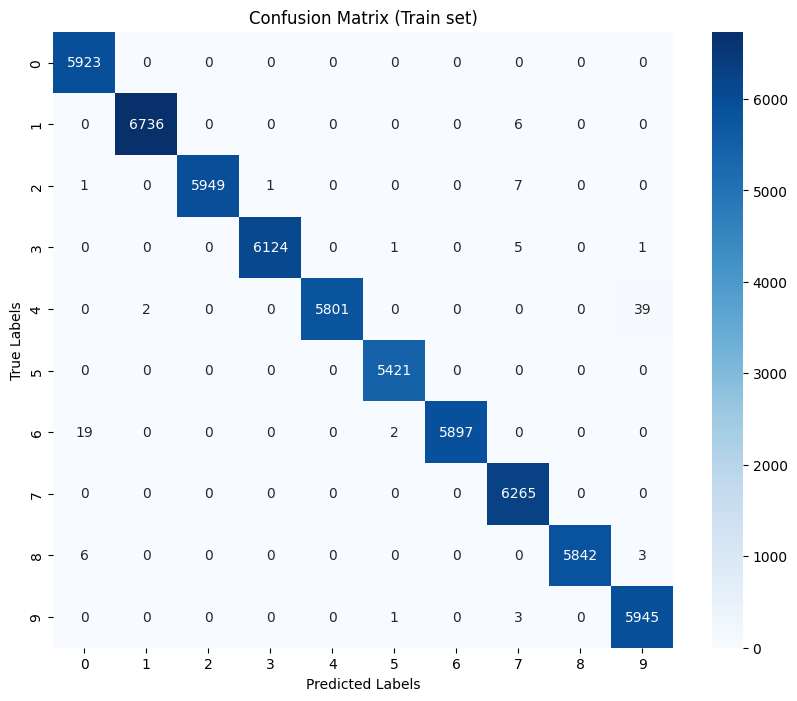

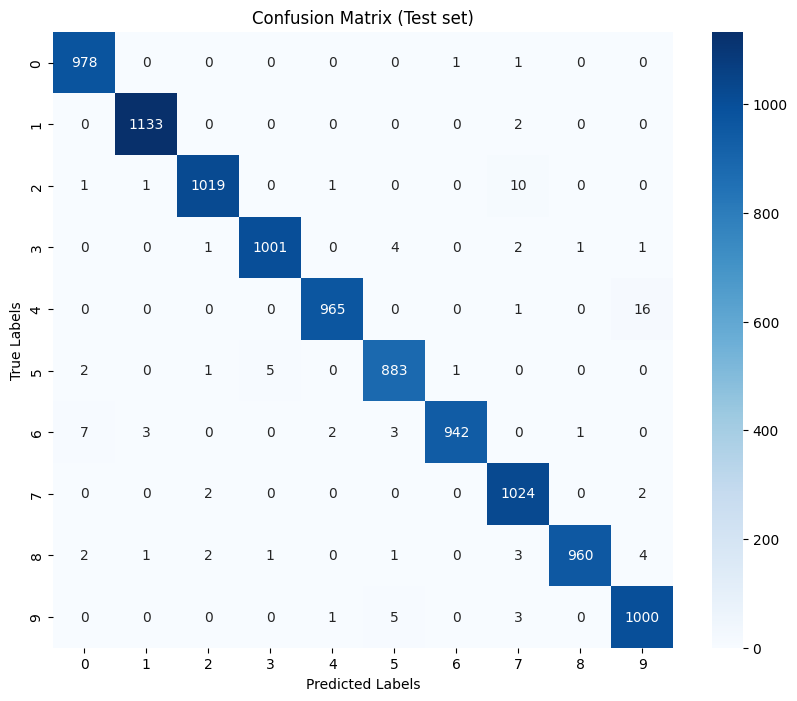

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import ConfusionMatrix

def plot_confusion_matrix(model, data_loader, device, split_name="Test"):
    model.eval()

    # labels
    all_labels = []
    # predicts
    all_preds = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)

            all_labels.append(y)
            all_preds.append(preds)

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    # Confusion matrix
    num_classes = 10
    cm_metric = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
    cm = cm_metric(all_preds, all_labels)  # preds, targets
    cm = cm.cpu().numpy()

    # Visualize
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix ({split_name} set)")
    plt.show()



plot_confusion_matrix(model_mnist, train_loader, device, split_name="Train")
plot_confusion_matrix(model_mnist, test_loader, device, split_name="Test")


## Save model pth format


In [ ]:

torch.save(model_mnist.state_dict(), "model_digit2.pth")
